# GWP 3

## Step 2

We first download the exact returns data which was used in GWP2 to have a "training" dataset.

C:\Users\adevr\AppData\Local\Temp\ipykernel_3104\3177327235.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices_train = yf.download(tickers, start=train_start_date, end=train_end_date)['Close']
[*********************100%***********************]  8 of 8 completed

Training Set Returns:
Ticker          AAPL      AMZN     GOOGL      META      MSFT      NFLX  \
Date                                                                     
2024-03-04 -0.025381 -0.003591 -0.027636 -0.008182 -0.001396 -0.005667   
2024-03-05 -0.028441 -0.019484 -0.005099 -0.015998 -0.029572 -0.028141   
2024-03-06 -0.005878 -0.003503 -0.009573  0.011974 -0.001391 -0.001353   
2024-03-07 -0.000709  0.019077  0.022679  0.032454  0.017533  0.018103   
2024-03-08  0.010237 -0.008314  0.007665 -0.012183 -0.007137 -0.006064   
...              ...       ...       ...       ...       ...       ...   
2024-11-11 -0.012029 -0.006437  0.011214 -0.010469 -0.010721  0.013081   
2024-11-12  0.000000  0.010008  0.007042  0.002829  0.012009  0.017456   
2024-11-13  0.003969  0.024843 -0.015086 -0.008242  0.005130  0.013386   
2024-11-14  0.013771 -0.012237 -0.018448 -0.004897  0.003975  0.008176   
2024-11-15 -0.014109 -0.041942 -0.017599 -0.039989 -0.027853 -0.015885   

Ticker         

<Axes: title={'center': 'Cumulative Returns of Training Set'}, xlabel='Date'>

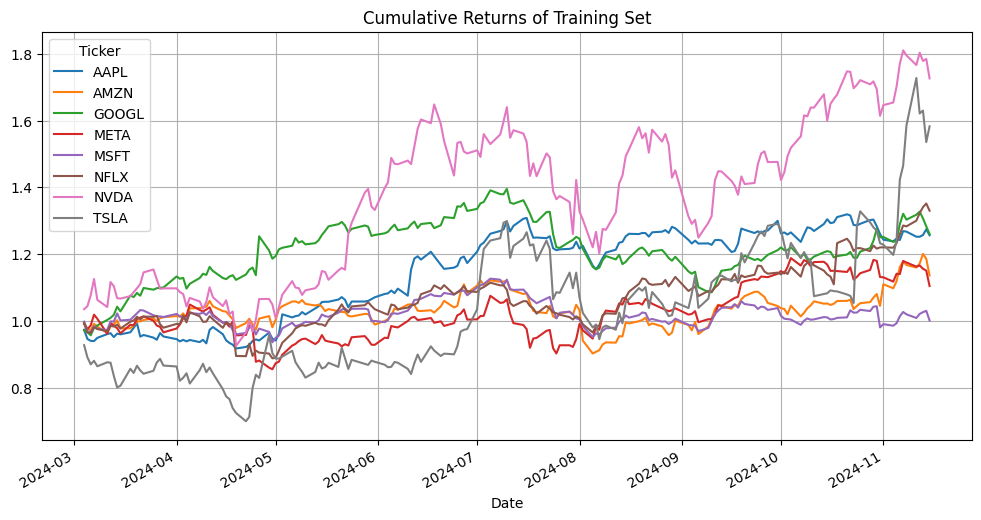

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

train_start_date = "2024-03-01"
dates = pd.date_range(start='2024-01-23', periods=300, freq='D')
train_end_date = dates[-1]
tickers = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NFLX']

prices_train = yf.download(tickers, start=train_start_date, end=train_end_date)['Close']
returns_train = prices_train.pct_change().dropna()
cum_returns_train = (1 + returns_train).cumprod()

print("Training Set Returns:")
print(returns_train)
cum_returns_train.plot(figsize=(12, 6), grid=True, title='Cumulative Returns of Training Set')

We then generate a "test" set, as mentioned on the GWP rubric.

In [131]:
test_start_date = train_end_date + pd.Timedelta(days=1)
test_end_date = "2025-08-20"

prices_test = yf.download(tickers, start=test_start_date, end=test_end_date)['Close']
returns_test = prices_test.pct_change().dropna()
returns_test

C:\Users\adevr\AppData\Local\Temp\ipykernel_3104\1293130021.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices_test = yf.download(tickers, start=test_start_date, end=test_end_date)['Close']
[*********************100%***********************]  8 of 8 completed


Ticker,AAPL,AMZN,GOOGL,META,MSFT,NFLX,NVDA,TSLA
Date,,,,,,,,
2024-11-19,0.001140,0.014427,0.016087,0.012067,0.004883,0.028652,0.048948,0.021432
2024-11-20,0.003154,-0.008455,-0.012014,0.007895,-0.005505,0.014380,-0.007618,-0.011474
2024-11-21,-0.002096,-0.022181,-0.047449,-0.004297,-0.004317,0.015421,0.005347,-0.006988
2024-11-22,0.005908,-0.006351,-0.017121,-0.007015,0.010003,0.000345,-0.032181,0.038040
2024-11-25,0.013051,0.021966,0.017541,0.010677,0.004293,-0.035866,-0.041775,-0.039624
...,...,...,...,...,...,...,...,...
2025-08-13,0.016024,0.013952,-0.006787,-0.012557,-0.016363,-0.017008,-0.008572,-0.004284
2025-08-14,-0.002357,0.028589,0.004852,0.002628,0.003650,0.021687,0.002368,-0.011197
2025-08-15,-0.005112,0.000216,0.004730,0.003964,-0.004421,0.006818,-0.008625,-0.014959


The best performing portfolio in terms of reward/risk was the **Kelly Portfolio** in GWP2, which was the solution to the following optimization problem:

$max_f \quad (r + f^T (\mu - \large\mathbb{1} \normalsize r) - \large\frac{f^T \Sigma f}{2}) $

with constraints

$0 \le f_i \le 1 \qquad \text{for any} \quad 1\le i\le k$

$\Sigma_i^k f_i = 1 \qquad \text{for all} \quad 1\le i\le k$

Thus, we generate the optimal Kelly Portfolio again and save it as the *Vanilla Kelly Portfolio*, which will be compared to the other portfolios after the improvements are made: denoising, clustering and backtesting.

In [132]:
from scipy.optimize import minimize
r = 4.36 / 100 / 252  # we take the latest SOFR rate as our yearly risk-free rate, converted to daily return
mu = returns_train.mean(axis=0)
Sigma = returns_train.cov()
k = returns_train.shape[1]
ones_vector = np.ones(k)

# Define the objective function to be minimized
def g(f):
  col_f = f[:, np.newaxis]
  return -(r + np.dot(f, (mu - ones_vector*r)) - 0.5 * (col_f.T @ Sigma @ col_f))

# Assign initial value for f
f_init = np.array([1/k for asset in range(k)])

# Assign the constraint and bound
cons = ({'type': 'ineq', 'fun': lambda x:  1 - x.sum()})
bnds = tuple((0, 1) for f_i in f_init)

# Optimize
res = minimize(g, f_init, constraints=cons, bounds=bnds, tol=1e-12)
f_star = np.round(res.x, 4)
print("Optimal allocations vector:")
print(f_star)

Optimal allocations vector:
[0.     0.     0.     0.     0.     0.     0.7283 0.2717]


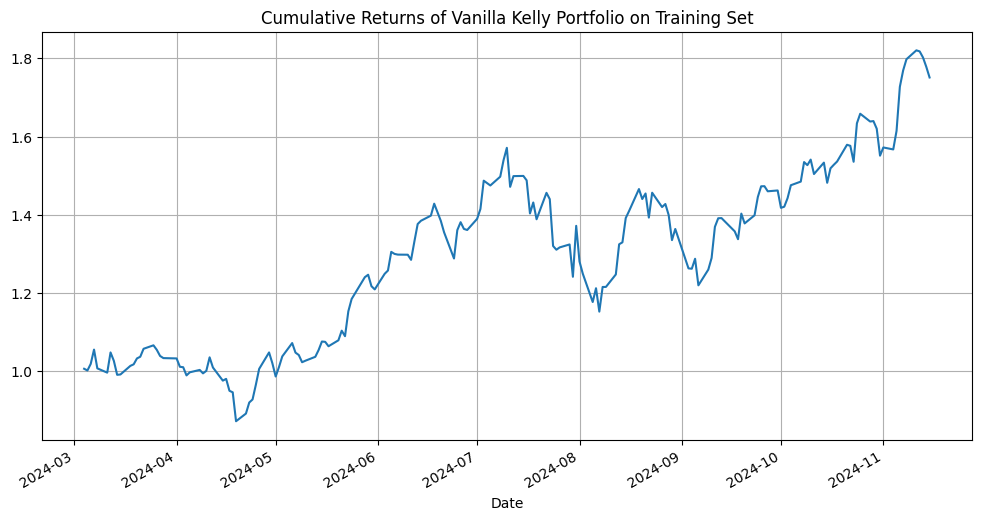

In [133]:
vanilla_kelly_portfolio_returns = (returns_train @ f_star[:, np.newaxis]).squeeze()
vanilla_kelly_portfolio_cum_returns = (1 + vanilla_kelly_portfolio_returns).cumprod()
vanilla_kelly_portfolio_cum_returns.plot(figsize=(12, 6), grid=True, title='Cumulative Returns of Vanilla Kelly Portfolio on Training Set')
plt.show()


Now, we generate the Kelly Portfolio with the same logic but in addition, we use portfolio optimization improvement techniques: denoising, clustering and backtesting.

### Denoising

We take the $(8 \times 8)$ correlation matrix $\Omega$ and apply eigendecomposition to it:

$\Omega = P D P^{-1}$

where,

$\Omega:$ Correlation matrix of the assets

$P:$ Principal components matrix (columns are the principal components)

$D:$ Diagonal matrix of eigenvalues

In [134]:
r

0.00017301587301587302

In [135]:
np.set_printoptions(precision=4, suppress=True)

Sigma = returns_train.cov()  # Covariance matrix
Omega = returns_train.corr()  # Correlation matrix
sigma = np.sqrt(np.diag(Sigma)) * np.eye(k)  # Diagonal volatilities matrix

eigvals, eigM = np.linalg.eigh(Omega)

print("Eigenvalues of the correlation matrix:")
print(np.round(eigvals[::-1], 6))
print()

P = eigM[:, ::-1]  # Eigenvectors matrix, columns flipped for descending eigenvalues
D = (eigvals[::-1] * np.eye(k))  # Diagonal matrix of eigenvalues, sorted in descending order
s = mu - r * ones_vector  # Excess returns vector

print("Eigenvectors matrix:")
print(P)
print()

print("Reconstructed correlation matrix:")
print((P @ D @ P.T))

Eigenvalues of the correlation matrix:
[3.8166 0.9643 0.786  0.6746 0.5365 0.4976 0.4399 0.2845]

Eigenvectors matrix:
[[-0.3017 -0.4755 -0.126  -0.7581 -0.1343  0.1031  0.0887 -0.236 ]
 [-0.4036  0.1052 -0.1523  0.2662  0.2107 -0.1976  0.689  -0.4168]
 [-0.3697  0.0931 -0.3952  0.1742  0.3275  0.6471 -0.3625 -0.1034]
 [-0.3672  0.3877 -0.1688 -0.0359 -0.3884 -0.4762 -0.4817 -0.2747]
 [-0.4329  0.1336 -0.2287 -0.0899 -0.1189 -0.0675  0.2212  0.8165]
 [-0.3412  0.0575  0.5785 -0.1911  0.6352 -0.2279 -0.2164  0.083 ]
 [-0.3356  0.0883  0.6239  0.1573 -0.5059  0.4399  0.1076 -0.0667]
 [-0.2412 -0.7582 -0.0007  0.5034 -0.0767 -0.2341 -0.2158  0.0794]]

Reconstructed correlation matrix:
[[1.     0.3251 0.3355 0.2833 0.4648 0.3355 0.2714 0.3477]
 [0.3251 1.     0.5333 0.5082 0.655  0.4467 0.4195 0.3246]
 [0.3355 0.5333 1.     0.4644 0.5813 0.3547 0.3436 0.2748]
 [0.2833 0.5082 0.4644 1.     0.6191 0.3884 0.4003 0.1533]
 [0.4648 0.655  0.5813 0.6191 1.     0.444  0.4566 0.2805]
 [0.3355 0.446

Thus, we get an eigenvectors matrix $P$ where column $j$ corresponds to the eigenvalue $j$ inside the eigenvalues vector $D$. We can think of the eigenvectors as asset weights and thus, because we have $8$ columns, we can construct $8$ **eigenportfolios** which will be linearly independent from each other by construction. Moreover, these eigenportfolios will have descending risk: 1st eigenportfolio will be the riskiest, while the 8th eigenportfolio will be the least risky portfolio.

In [ ]:
# returns_train.shape = (180, 8)
# P.shape = (8, 8)
# -> eigenportfolios_returns_train.shape = (180, 8)
riskfree_weights_train = (1 - P.sum(axis=0))
print("Risk-free weights for eigenportfolios (excess weight from asset allocations):")
print(riskfree_weights_train)
print()
eigenportfolios_excess_returns_train = (returns_train @ P)
eigenportfolios_returns_train = eigenportfolios_excess_returns_train + riskfree_weights_train * r  # Adding risk-free return component
eigenportfolios_returns_train.columns = [f'Eigenportfolio {i+1}' for i in range(k)]
eigenportfolios_returns_train

Risk-free weights for eigenportfolios (excess weight from asset allocations):
[3.793  1.3682 0.8693 0.9739 1.0507 1.013  1.1698 1.1187]



,Eigenportfolio 1,Eigenportfolio 2,Eigenportfolio 3,Eigenportfolio 4,Eigenportfolio 5,Eigenportfolio 6,Eigenportfolio 7,Eigenportfolio 8
Date,,,,,,,,
2024-03-04,0.030716,0.063097,0.035724,-0.015229,-0.019176,0.018229,0.029661,0.003095
2024-03-05,0.053871,0.030044,0.007281,0.005812,-0.011245,0.026797,0.002766,-0.010228
2024-03-06,-0.001026,0.026581,0.022597,-0.004715,-0.022567,0.008208,0.003392,-0.004475
2024-03-07,-0.058794,0.015550,0.017266,0.016590,-0.015021,0.007135,-0.008375,-0.005068
2024-03-08,0.030806,-0.001670,-0.037323,-0.024285,0.030783,-0.004572,-0.003763,-0.000302
...,...,...,...,...,...,...,...,...
2024-11-11,-0.009461,-0.067765,-0.000082,0.050950,0.019015,-0.017842,-0.030585,0.007949
2024-11-12,-0.010358,0.054088,0.015778,-0.028118,0.007318,0.020180,0.017568,-0.000499
2024-11-13,-0.005467,-0.007425,0.001289,-0.001040,0.017520,-0.020799,0.022735,-0.000644


<Axes: title={'center': 'Cumulative Returns of Eigenportfolios on Training Set'}, xlabel='Date'>

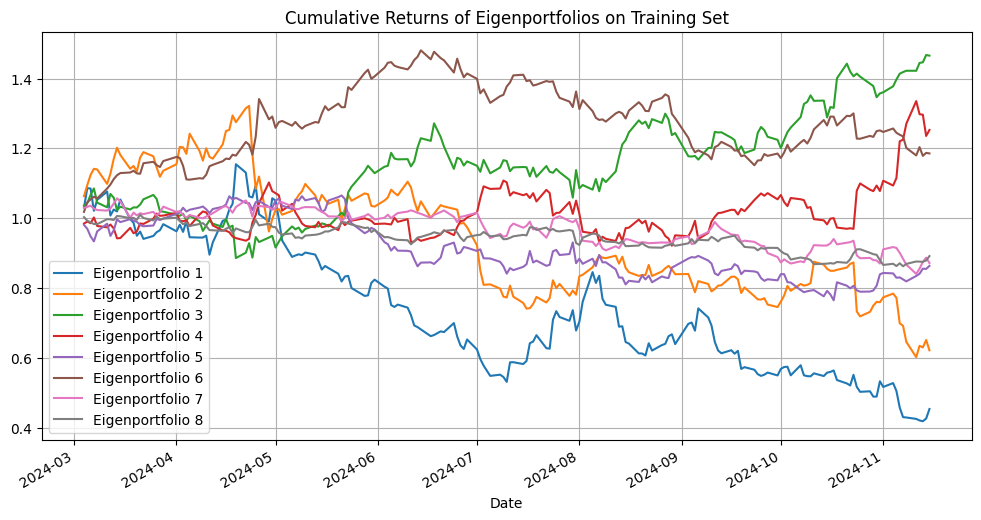

In [137]:
(1 + eigenportfolios_returns_train).cumprod().plot(figsize=(12, 6), grid=True, title='Cumulative Returns of Eigenportfolios on Training Set')

In [138]:
s_P = P.T @ np.linalg.inv(sigma) @ s  # Expected excess returns of eigenportfolios
s_P

array([-0.1575, -0.0601,  0.0641,  0.0009,  0.0103,  0.0416, -0.0328,
       -0.0489])

In [139]:
w = 0.75  # shrinkage coefficient